In [1]:
using CSV
using DataFrames
using Dates
using ProgressMeter
using Gadfly

In [2]:
ENV["COLUMNS"] = 1000;

In [3]:
rawdata = DataFrame(CSV.File("../rawdata/md_data_2020_12_01.csv", missingstring="null"));

In [4]:
hospitals = sort(unique(rawdata[!,"Facility Name"]));

In [5]:
get_hospital_id(h) = h |> hash |> string |> (x -> "h" * x[end-7:end]);

In [6]:
convert_date(d) = Date(d, dateformat"m/d/y") + Year(2000);

In [7]:
data = select(rawdata,
    "Facility Name" => :hospital,
    "Facility Name" => ByRow(get_hospital_id) => :hospital_id,
    "Modified Date" => ByRow(convert_date) => :date,
    
    "COVID-19 Patients in Acute Care Beds" => :active_acute,
    "COVID-19 Patients in ICU" => :active_icu,
);
data.active_allbeds = data.active_acute + data.active_icu
sort!(data, [:hospital, :date]);

In [8]:
first(data, 50)

,hospital,hospital_id,date,active_acute,active_icu,active_allbeds
,String,String,Date,Int64?,Int64?,Int64?
1,Anne Arundel Medical Center,h39740093,2020-03-25,4,3,7
2,Anne Arundel Medical Center,h39740093,2020-03-26,8,1,9
3,Anne Arundel Medical Center,h39740093,2020-03-27,11,3,14
4,Anne Arundel Medical Center,h39740093,2020-03-28,11,4,15
5,Anne Arundel Medical Center,h39740093,2020-03-29,8,4,12
6,Anne Arundel Medical Center,h39740093,2020-03-30,8,3,11
7,Anne Arundel Medical Center,h39740093,2020-03-31,10,4,14
8,Anne Arundel Medical Center,h39740093,2020-04-01,missing,missing,missing
9,Anne Arundel Medical Center,h39740093,2020-04-02,8,6,14


In [9]:
data |> CSV.write("../data/data_historical.csv");

In [10]:
isbad(x) = ismissing(x) || isnan(x) || isinf(x);
skipbad(xs) = filter(x -> !isbad(x), xs);

In [11]:
data_total = combine(groupby(data, :date), [
    :active_allbeds => (x -> sum(skipbad(x))) => :active_allbeds_total,
    :active_icu => (x -> sum(skipbad(x))) => :active_icu_total,
    :active_acute => (x -> sum(skipbad(x))) => :active_acute_total,
]);

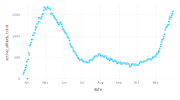

In [12]:
plot(
    data_total,
    x = :date,
    y = :active_allbeds_total,
    Coord.cartesian(ymin=0),
    Scale.y_continuous(format=:plain),
) |> SVG(18cm, 10cm)